# Residual Connections

[Kaiming He et al., "Deep residual layer fr image recognition", CVPR 2016](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)

Given a mapping  $g : \mathbb{R}^d \to \mathbb{R}^d$, a residual connection is defined as
$$
f(x) = x + g(x).
$$

## Gradient does not vanishes

Let $f(w)=g_2(ag_1(w)+b)$ and $f_r(w)=g_1(w)+g_2(ag_1(w)+b)$.
$$
\begin{align*}
\frac{\partial f(w)}{\partial w}&=ag'_2(ag_1(w)+b)g'_1(w),\\
\frac{\partial f_r(w)}{\partial w}&=ag'_2(ag_1(w)+b)g'_1(w)+g_1'(w)=(\underbrace{ag'_2(ag_1(w)+b)+1}_{\approx 1})g'_1(w)
\end{align*}
$$

## Definition

Input
* $x \in \mathbb{R}^{d_{in}}$ 

Weights
* weight $W \in \mathbb{R}^{d_{out}\times d_{in}}$ 
* bias $b \in \mathbb{R}^{d_{out}}$

Output
* $o \in \mathbb{R}^{d_{out}}$

$$o = \text{ResConn}_{f}(x)=f(x)+\begin{cases}x,& \text{if } d_{in}=d_{out}\\
\operatorname{Linear}_{W,b}(x),& \text{if } d_{in}\neq d_{out}\\
\end{cases}.$$

where $f:\mathbb{R}^{d_{in}} \mapsto \mathbb{R}^{d_{out}}$ is the "skipped block".

## Code

In [3]:
import torch.nn as nn

class ResidualConnection(nn.Module):
    def __init__(self,block:nn.Module, in_dim:int, out_dim:int):
        super().__init__()
        self.block = block
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        return self.block(x) + self.skip(x)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU(),res_connect:bool=False):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dims:
            block = nn.Sequential(nn.Linear(in_dim,h_dim),
                                  nn.LayerNorm(h_dim),
                                    activation)
            if res_connect:
                layers.append(ResidualConnection(block, in_dim, h_dim))
            else:
                layers.append(block)
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## Testing

Compare with no skip conneciton

In [4]:
import torch
import torchvision
from PIL import Image

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("mps")

### Create Dataset

In [5]:
size = (128,128)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size),torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'train', download=True, transform=transform)
test_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'test', download=True, transform=transform)

100.0%
100.0%
100.0%


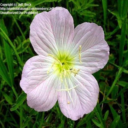

In [6]:
def visualize_image(img: torch.Tensor) -> Image.Image:
    return Image.fromarray((img.permute(1, 2, 0) * 255).to(torch.uint8).numpy())
visualize_image(train_dataset[1][0])

In [7]:
lr = 0.001
momentum = 0.9
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset), shuffle=False)

### Train

#### MLP

In [8]:
torch.manual_seed(1)

mlp = MLP(input_dim=size[0]*size[1]*3,
            hidden_dims=[512,512,512],
            output_dim=102
        ).to(device)


optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum)

mlp.train()
losses = []
for epoch in range(30):
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        pred_y = mlp(img)
        optimizer.zero_grad()
        loss_value = loss(pred_y, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, loss: {sum(losses)/len(losses)}")

Epoch 0, loss: 4.705150067806244
Epoch 1, loss: 4.652520999312401
Epoch 2, loss: 4.583967824776967
Epoch 3, loss: 4.497884891927242
Epoch 4, loss: 4.407962684333325
Epoch 5, loss: 4.315529711544514
Epoch 6, loss: 4.223264140742166
Epoch 7, loss: 4.132614059373736
Epoch 8, loss: 4.041934774153763
Epoch 9, loss: 3.948984105885029
Epoch 10, loss: 3.8541933474215595
Epoch 11, loss: 3.7589176781475544
Epoch 12, loss: 3.665802156695953
Epoch 13, loss: 3.5732102218483175
Epoch 14, loss: 3.4836081626514592
Epoch 15, loss: 3.389456962933764
Epoch 16, loss: 3.2986351043424187
Epoch 17, loss: 3.204958595749405
Epoch 18, loss: 3.11073066882397
Epoch 19, loss: 3.017510797828436
Epoch 20, loss: 2.926561459278067
Epoch 21, loss: 2.8363762933930214
Epoch 22, loss: 2.7480021508653527
Epoch 23, loss: 2.6606434393130862
Epoch 24, loss: 2.5788042002171276
Epoch 25, loss: 2.497254207622833
Epoch 26, loss: 2.4186642253081554
Epoch 27, loss: 2.3433260661050945
Epoch 28, loss: 2.2709066286554624
Epoch 29, los

In [9]:
torch.manual_seed(1)

skipmlp = MLP(input_dim=size[0]*size[1]*3,
            hidden_dims=[512,512,512],
            output_dim=102,
            res_connect=True
        ).to(device)


optimizer = torch.optim.SGD(skipmlp.parameters(), lr=lr, momentum=momentum)

skipmlp.train()
skip_losses = []
for epoch in range(30):
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        pred_y = skipmlp(img)
        optimizer.zero_grad()
        loss_value = loss(pred_y, label)
        loss_value.backward()
        optimizer.step()
        skip_losses.append(loss_value.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, loss: {sum(skip_losses)/len(skip_losses)}")

Epoch 0, loss: 4.861629769206047
Epoch 1, loss: 4.509859275072813
Epoch 2, loss: 4.171918496489525
Epoch 3, loss: 3.878960905596614
Epoch 4, loss: 3.620813582837582
Epoch 5, loss: 3.3803893017272153
Epoch 6, loss: 3.1690285243093967
Epoch 7, loss: 2.976044438313693
Epoch 8, loss: 2.7846566221366325
Epoch 9, loss: 2.6080842088907956
Epoch 10, loss: 2.448368777097626
Epoch 11, loss: 2.2997901739242175
Epoch 12, loss: 2.1622143410719357
Epoch 13, loss: 2.0339171970263124
Epoch 14, loss: 1.9169689665548504
Epoch 15, loss: 1.809264559095027
Epoch 16, loss: 1.7113644324160893
Epoch 17, loss: 1.6219170684796862
Epoch 18, loss: 1.5403759432772763
Epoch 19, loss: 1.4658848847378976
Epoch 20, loss: 1.397826890699521
Epoch 21, loss: 1.3357162927780089
Epoch 22, loss: 1.278804379677319
Epoch 23, loss: 1.226500907553903
Epoch 24, loss: 1.1782868904341013
Epoch 25, loss: 1.1336967756729932
Epoch 26, loss: 1.092342995106096
Epoch 27, loss: 1.0538959567597235
Epoch 28, loss: 1.0180598084497716
Epoch 2

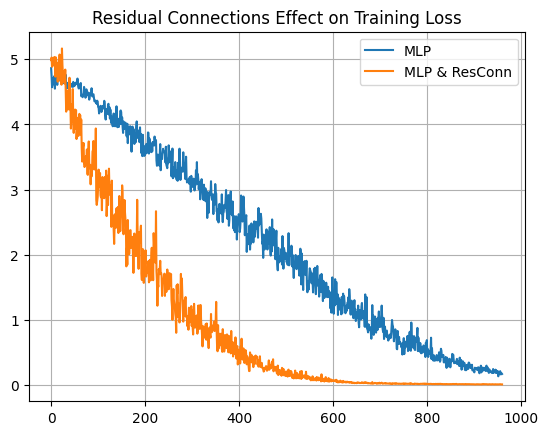

In [10]:
plt.plot(losses,linestyle="-",label="MLP")
plt.plot(skip_losses,linestyle="-",label="MLP & ResConn")
plt.title("Residual Connections Effect on Training Loss")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation

In [11]:
for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    prred_test = mlp(test_images)
    accuracy = ((prred_test.argmax(dim=1) == test_labels).float().mean()).item()
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.14831680059432983


In [12]:
for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    prred_test = skipmlp(test_images)
    accuracy = ((prred_test.argmax(dim=1) == test_labels).float().mean()).item()
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.15465930104255676
